# 네이버 뉴스 기사 크롤링

In [1]:
from bs4 import BeautifulSoup
import requests
import time
import re
import datetime
from tqdm import tqdm
import sys
from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
import pandas as pd
from PIL import Image
import numpy as np
%matplotlib inline
from konlpy.tag import Mecab
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
from konlpy.tag import Kkma
pd.options.plotting.backend = "plotly"

#웹드라이버 설정
service = Service(executable_path=f"C:/Users/user/Desktop/학기별 문서/현장실습/크롤링_워드클라우드/chromedriver-win64/chromedriver.exe")
options = webdriver.ChromeOptions()
options.add_argument("headless")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option("useAutomationExtension", False)

In [2]:
# 페이지 url 형식에 맞게 바꾸어 주는 함수 만들기
  #입력된 수를 1, 11, 21, 31 ...만들어 주는 함수
def makePgNum(num):
    if num == 1:
        return num
    elif num == 0:
        return num+1
    else:
        return num+9*(num-1)

# 크롤링할 url 생성하는 함수 만들기(검색어, 크롤링 시작 페이지, 크롤링 종료 페이지)
def makeUrl(search, start_pg, end_pg, s_date, e_date):
    urls = []
    s_from = s_date.replace(".", "")
    e_to = e_date.replace(".", "")
    for i in range(start_pg, end_pg + 1):
        page = makePgNum(i)
        url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search + "&sort=0&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "&start=" + str(page)
        urls.append(url)
#     print("생성url: ", urls)
    return urls    

In [5]:
# 검색어를 기준으로 1~10 페이지 Url 생성
keyword = input('input keyword : ')
s_date = input('input start_date : ')
e_date = input('input end_date : ')
url = makeUrl(keyword, 1, 10, s_date, e_date)



## selenium으로 navernews만 뽑아오기##
# 버전에 상관 없이 os에 설치된 크롬 브라우저 사용
driver = webdriver.Chrome(options=options, service=service)
driver.implicitly_wait(3)


# selenium으로 검색 페이지 불러오기 #
print("준비중...")
naver_urls=[]

for i in url:
    driver.get(i)
    time.sleep(1) #대기시간 변경 가능

    # 네이버 기사 눌러서 제목 및 본문 가져오기#
    # 네이버 기사가 있는 기사 css selector 모아오기
    a = driver.find_elements(By.CSS_SELECTOR,'a.info')

    # 위에서 생성한 css selector list 하나씩 클릭하여 본문 url얻기
    for i in a:
        # 네이버 뉴스 url만 가져오기
        if i.text == '네이버뉴스':
            i.click()

            # 현재탭에 접근
            driver.switch_to.window(driver.window_handles[1])
            driver.implicitly_wait(3) #대기시간 변경 가능

            # 네이버뉴스의 특정 도메인만을 수집
            url = driver.current_url
            if url.find("n.news.naver.com") != -1:
                print(url)
                naver_urls.append(url)

            # 현재 탭 닫기
            driver.close()

            # 다시처음 탭으로 돌아가기(매우 중요!!!)
            driver.switch_to.window(driver.window_handles[0])

if len(naver_urls) == 0:
    print("크롤링 할 수 있는 뉴스기사가 없습니다...")
else:
    print("모든 기사 url 수집 완료")

input keyword : 별똥별
input start_date : 2023.08.01
input end_date : 2023.08.11
준비중...
https://n.news.naver.com/mnews/article/020/0003514383?sid=102
https://n.news.naver.com/mnews/article/277/0005298093?sid=105
https://n.news.naver.com/mnews/article/366/0000922901?sid=105
https://n.news.naver.com/mnews/article/052/0001919495?sid=103
https://n.news.naver.com/mnews/article/437/0000353559?sid=102
https://n.news.naver.com/mnews/article/658/0000048331?sid=105
https://n.news.naver.com/mnews/article/005/0001627785?sid=103
모든 기사 url 수집 완료


In [7]:
###naver 기사 본문 및 제목 가져오기###

# ConnectionError방지
headers = { "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/98.0.4758.102" }

titles = []
contents=[]
num = 1
print("제목, 본문 가져오는중...")
for i in naver_urls:
    original_html = requests.get(i,headers=headers)
    html = BeautifulSoup(original_html.text, "html.parser")
    # 검색결과확인시
    # print(html)
    
    #뉴스 제목 가져오기
    title = html.select("div.media_end_head_title > h2")
    
    # list합치기
    title = ''.join(str(title))
    
    # html태그제거
    pattern1 = '<[^>]*>'
    title = re.sub(pattern=pattern1,repl='',string=title)
    
    # 출력
    titles.append(title[1:len(title)-1])
    print(str(num) + ". " + title[1:len(title)-1])
    num = num + 1
    
    #뉴스 본문 가져오기
    content = html.select("div#contents > div#newsct_article")

    # list합치기
    content = ''.join(str(content))
    
    #html태그제거 및 텍스트 다듬기
    content = re.sub(pattern=pattern1,repl='',string=content)
    pattern2 = """[\n\n\n\n\n// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_removeCallback() {}"""
    content = content.replace(pattern2,'')

    contents.append(content)

# csv 파일로 기사제목과 url 저장
# data = {"url" : naver_urls, "title" : titles}
# df = pd.DataFrame(data)
# df.to_csv(keyword + ".csv", encoding = "utf-8-sig")
    
titles_all = ""
contents_all = ""
news_all = ""

# 기사 별 제목 모두 합치기(string)
for i in titles:
    titles_all = titles_all + " " + i

# 기사 별 내용 모두 합치기(string)
for i in contents:
    contents_all = contents_all + " " + i

# 제목 + 기사 모두 합치기(string)
news_all = titles_all + contents_all

# 네이버뉴스의 태그가 위 조건에 맞지 않아 뉴스가 없을 경우 예외처리 
if len(news_all) == 0 :
    print("크롤링 실패..")
else:
    print("모든 기사 제목/본문 크롤링 완료")

제목, 본문 가져오는중...
1. “페르세우스 별똥별 집에서 감상해요”
2. 일요일 밤 '시간당 90개' 별똥별 쏟아진다
3. 폭염 후 밤하늘에 우주쇼 펼쳐진다… 별똥별에 슈퍼 블루문까지
4. 8월 폭염 기세 꺾이면 유성우·슈퍼 블루문 장관
5. '슈퍼문, 페르세우스 유성우' 무더위 날릴 8월의 우주쇼 열려
6. [60초 뉴스]우주쇼 펼쳐지는 8월...‘유성우’부터 ‘슈퍼문’까지
7. [김국애 원장의 미용 에세이] 간격
모든 기사 제목/본문 크롤링 완료


('유성우', 73)
('슈퍼문', 42)
('페르세우스', 33)
('지구', 25)
('보름달', 18)
('밤하늘', 17)
('블루문', 17)
('관측', 15)
('하늘', 15)
('때문', 14)
('시간', 13)
('가장', 12)
('새벽', 12)
('올해', 12)
('우주', 11)
('슈퍼', 10)
('아들', 10)
('거리', 9)
('현상', 8)
('예정', 8)
('혜성', 8)
('자리', 8)
('이번', 8)
('평소', 8)
('지난', 8)
('우리', 8)
('천문대', 7)
('하나', 7)
('달이', 7)
('미국', 7)
('부모', 7)
('쌍둥이자리', 6)
('페르세우스자리', 6)
('사진', 6)
('유성', 6)
('평균', 6)
('가족', 6)
('폭염', 5)
('생중계', 5)
('구산', 5)
('온라인', 5)
('사분의자리', 5)
('전망', 5)
('차례', 5)
('가운데', 5)
('모두', 5)
('아버지', 5)
('인종차별', 5)
('마음', 5)
('자식', 5)
('흑인', 5)
('사랑', 5)
('무리', 4)
('태양', 4)
('통해', 4)
('다음', 4)
('궤도', 4)
('스위프트', 4)
('터틀', 4)
('최적', 4)
('중심', 4)
('이름', 4)
('얘기', 4)
('아픔', 4)
('여자', 4)
('생각', 4)
('감상', 3)
('기세', 3)
('간격', 3)
('유튜브', 3)
('채널', 3)
('촬영', 3)
('모습', 3)
('기회', 3)
('파편', 3)
('다량', 3)
('대기권', 3)
('지역', 3)
('저녁', 3)
('굴절망원경', 3)
('사람', 3)
('국립과천과학관', 3)
('연중', 3)
('영향', 3)
('과학관', 3)
('더욱', 3)
('세계', 3)
('북동쪽', 3)
('타원형', 3)
('이기', 3)
('어디', 3)
('달리', 3)
('보통', 3)
('비교', 3)
('

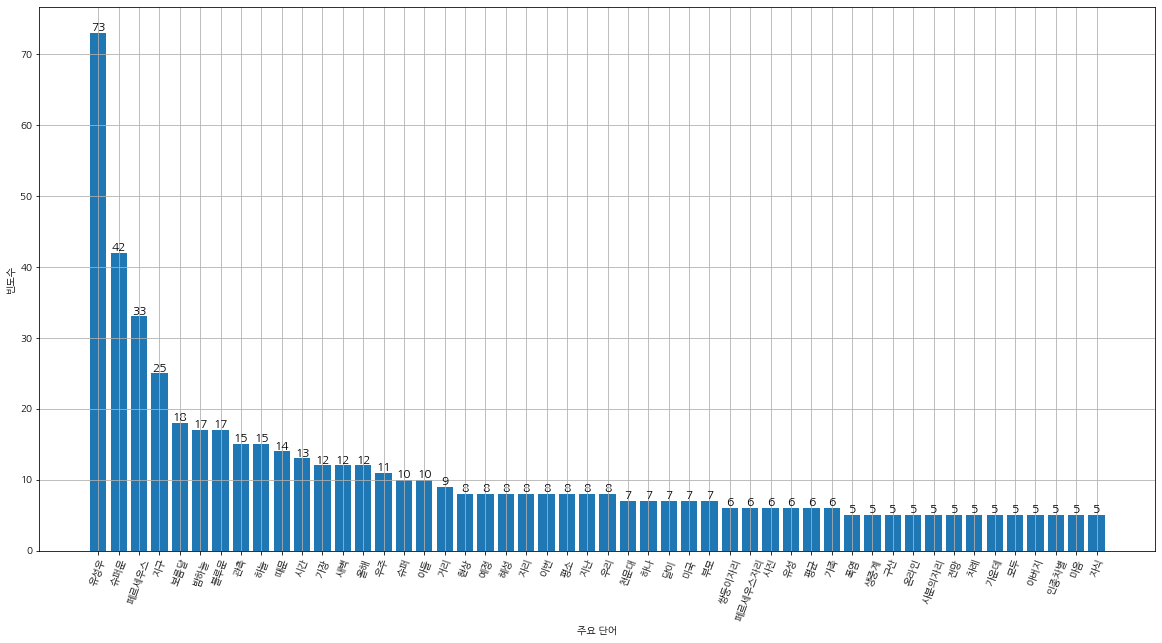

In [8]:
okt = Okt()

noun = okt.nouns(news_all)

nouns = []
# 두글자 이상 단어만 취급
word = [w for w in noun if len(w) > 1]
nouns.extend(word)

nouns = [i for i in nouns if i not in keyword]

# 빈도수 계산
count = Counter(nouns)

# 제거할 불필요한 단어 리스트
ignore = ["오전", "오후", "기자", "뉴스", "연합뉴스", "최대", "최소", "경우", "정도", "예상", "회의", "단계", "발생", "가장", "올해", "평소"]
for word in ignore:
    if word in count:
        del count[word] # 제거

# 상위 100개 단어 출력
noun_list = count.most_common(100)
for v in noun_list:
    print(v)
    
# 빈도수 그래프 나타내기
wordInfo = dict() # 딕셔너리
for tags, counts in count.most_common(50):
    wordInfo[tags] = counts

Sorted_Dict_Values = sorted(wordInfo.values(), reverse=True) # 빈도수 저장
Sorted_Dict_Keys = sorted(wordInfo, key=wordInfo.get, reverse=True) # 단어 저장

# 전역으로 그래프 사이즈 고정
plt.rcParams["figure.figsize"] = (12,5)

# 유니코드 깨짐현상 해결
plt.rcParams['axes.unicode_minus'] = False
    
# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

# 바 그래프 그리기
plt.figure(figsize = (20,10))
bar = plt.bar(range(len(wordInfo)), Sorted_Dict_Values, align='center')
plt.xticks(range(len(wordInfo)), list(Sorted_Dict_Keys), rotation='70')
plt.xlabel("주요 단어")
plt.ylabel("빈도수")
# 숫자 넣는 부분
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height, '%d' % height, ha='center', va='bottom', size = 12)
plt.grid()
plt.show()

(-0.5, 799.5, 599.5, -0.5)

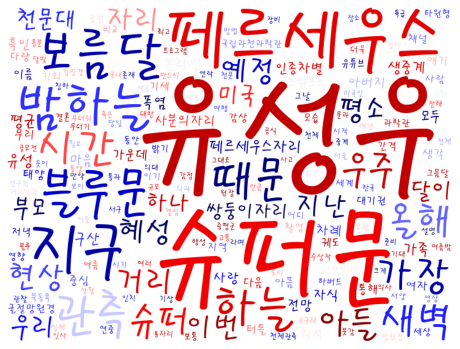

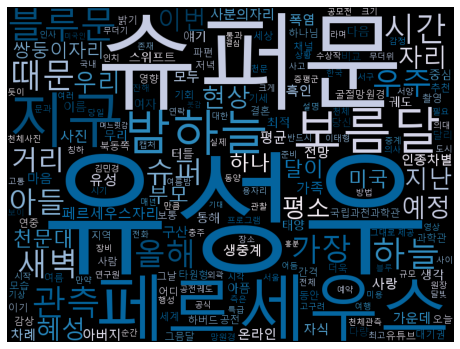

In [9]:
# 워드 클라우드 구현
wc = WordCloud(font_path = 'C:/Windows/Fonts/HMFMPYUN.ttf', background_color = 'white', colormap = 'seismic',width = 800, height = 600, prefer_horizontal = True) # malgun = 맑음 # spring, summer, seismic, PuBu
cloud = wc.generate_from_frequencies(count)
plt.figure(figsize = (8,8))
plt.imshow(cloud)
plt.axis('off')

wc2 = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color = 'black', colormap = 'PuBu',width = 800, height = 600, prefer_horizontal = True) # malgun = 맑음 # spring, summer, seismic, PuBu
cloud2 = wc2.generate_from_frequencies(count)
plt.figure(figsize = (8,8))
plt.imshow(cloud2)
plt.axis('off')

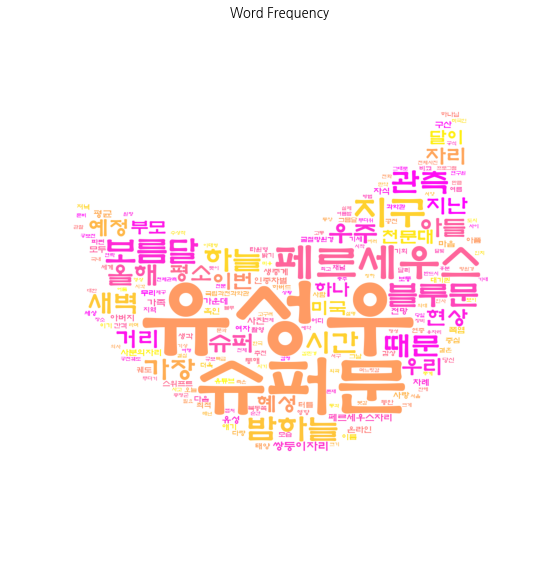

In [11]:
im = Image.open('banana.jpg') # 이미지 파일 읽어오기
mask_arr = np.array(im) # 픽셀 값 배열 형태 변환

wordcloud = WordCloud(font_path = 'HMFMOLD', background_color ='white', colormap='spring',
                      width = 800, height = 600, random_state = 43, mask = mask_arr,
                      prefer_horizontal = True).generate_from_frequencies(count)

plt.figure(figsize = (10, 10))  
plt.imshow(wordcloud)
plt.title("Word Frequency", size = 13)

plt.axis('off')

plt.show()